## Import Python Packages

In [1]:
import numpy as np
import scipy as sci
import pyDOE
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
import sklearn
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
nltk.download('punkt')
import re, string
from wordcloud import WordCloud
import seaborn as sns
sns.set_style('white')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
#nltk.download('all')
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
from sklearn.decomposition import LatentDirichletAllocation as LDA
from pyLDAvis import sklearn as sklearn_lda
import pyLDAvis
from textblob import TextBlob
import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dawei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dawei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dawei\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read in Data 

In [2]:
hotel_reviews_df=pd.read_csv('tripadvisor_hotel_reviews.csv')
hotel_reviews_df

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5
...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5
20487,great location price view hotel great quick pl...,4
20488,"ok just looks nice modern outside, desk staff ...",2
20489,hotel theft ruined vacation hotel opened sept ...,1


## Feature Engineering

In [3]:
hotel_reviews_df['Review_Length']=hotel_reviews_df['Review'].str.len()
hotel_reviews_df

,Review,Rating,Review_Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281
...,...,...,...
20486,"best kept secret 3rd time staying charm, not 5...",5,733
20487,great location price view hotel great quick pl...,4,306
20488,"ok just looks nice modern outside, desk staff ...",2,443
20489,hotel theft ruined vacation hotel opened sept ...,1,5557


## Data Visualization 

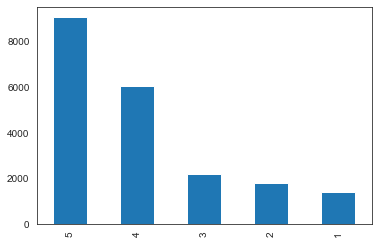

In [4]:
hotel_reviews_df['Rating'].value_counts().plot(kind='bar')

## Wordcloud

<>:3: DeprecationWarning: invalid escape sequence \.
<>:3: DeprecationWarning: invalid escape sequence \.
<ipython-input-5-22673c87d4ba>:3: DeprecationWarning: invalid escape sequence \.
  hotel_reviews_df['review_text_processed'] = hotel_reviews_df['Review'].map(lambda x: re.sub('[,\.!?]', '', x))


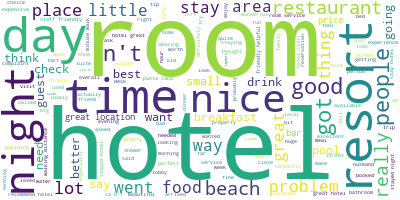

In [5]:
lemmatizer = WordNetLemmatizer()
# Remove punctuation
hotel_reviews_df['review_text_processed'] = hotel_reviews_df['Review'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the reviews to lowercase
hotel_reviews_df['review_text_processed'] = hotel_reviews_df['review_text_processed'].map(lambda x: x.lower())
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
hotel_reviews_df['review_text_processed'].apply(lemmatize_text)
# Print out the first rows of reviews
hotel_reviews_df['review_text_processed'].head()
# Join the different processed reviews together.
long_string = ','.join(list(hotel_reviews_df['review_text_processed'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Topic Modeling using LDA

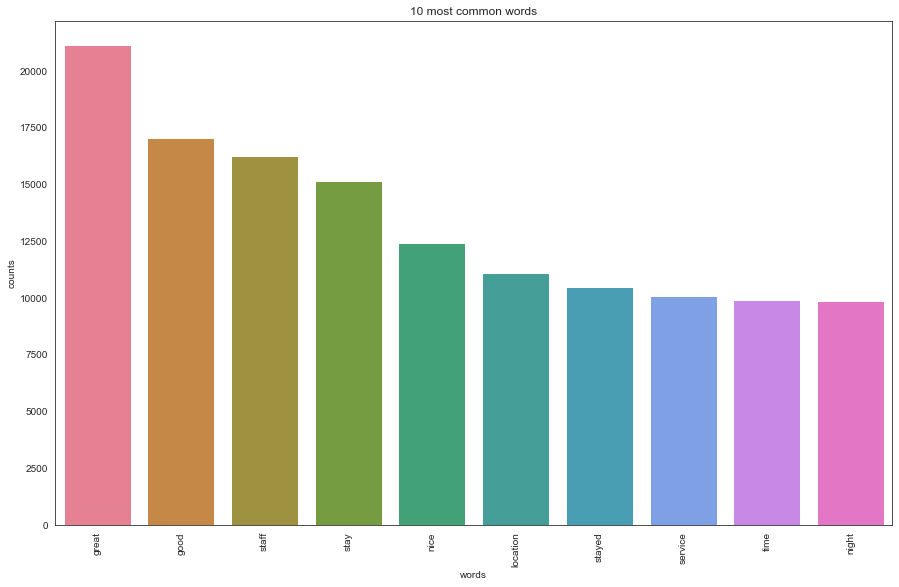

Topics found via LDA:

Topic #0:
great stay staff nice location stayed service good place view

Topic #1:
beach resort food good pool great time day people nice

Topic #2:
great good location staff stay breakfast stayed clean nice small

Topic #3:
stay desk night service told like staff day check got

Topic #4:
food good great staff holiday restaurant got bar buffet breakfast


In [6]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['just','room','rooms','hotel','went']
stopwords.extend(newStopWords)
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=stopwords)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(hotel_reviews_df['review_text_processed'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)
LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
pyLDAvis.display(LDAvis_prepared)

## Sentiment Analysis with TextBlob

Final summarized counts : [4404, 13974, 2113]

 Pie Representation 
-------------------


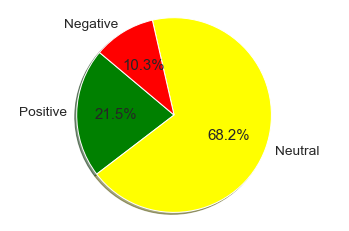

In [7]:
hotel_reviews_df['sentiment'] = hotel_reviews_df['review_text_processed'].apply(lambda text: TextBlob(text).sentiment)
hotel_reviews_df
#Categorize Polarity into Positive, Neutral or Negative
labels = ["Positive", "Neutral", "Negative"]
#Initialize count array
values =[0,0,0]

#Categorize each review
for text in hotel_reviews_df['review_text_processed']:
    sentiment = TextBlob(text)
    
    #Custom formula to convert polarity 
    # 0 = (Negative) 1 = (Neutral) 2=(Positive)
    polarity = round(( sentiment.polarity + 1 ) * 3 ) % 3
    
    #add the summary array
    values[polarity] = values[polarity] + 1
    
print("Final summarized counts :", values)

import matplotlib.pyplot as plt
#Set colors by label
colors=["Green","Yellow","Red"]

print("\n Pie Representation \n-------------------")
#Plot a pie chart
plt.pie(values, labels=labels, colors=colors, \
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

## Review Classification

In [16]:
x = hotel_reviews_df["Review"].copy()
y = hotel_reviews_df["Rating"].copy()
def clean_text(review):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    review = review.lower()
    review = re.sub('\[.*?\]', '', review)
    review = re.sub('[%s]' % re.escape(string.punctuation), '', review)
    review = re.sub('\w*\d\w*', '', review)
    review = re.sub('[‘’“”…]', '', review)
    review = re.sub('\n', '', review)
    stop_words=set(stopwords.words('english'))
    return review
round1 = lambda x: clean_text(x)
#df_clean = x.apply(round1)
tfidfconverter = TfidfVectorizer(max_features=400, min_df=0.05, max_df=0.9)
tfidf = tfidfconverter.fit_transform(hotel_reviews_df['Review']).toarray()
X_train,X_test,y_train,y_test = train_test_split(tfidf,y,test_size=0.2,random_state=42)
nb = MultinomialNB()
nb_bern = BernoulliNB()
gb_nb=GaussianNB()
nb_model=nb.fit(X_train,y_train)
nb_bern_model=nb_bern.fit(X_train,y_train)
gb_nb_bern_model=gb_nb.fit(X_train,y_train)
y_pred=nb_model.predict(X_test)
y_pred2=nb_bern_model.predict(X_test)
y_pred3=gb_nb_bern_model.predict(X_test)
print("Accuracy Multinominal:",accuracy_score(y_test, y_pred))
print("Accuracy Bernoulli:",accuracy_score(y_test, y_pred2))
print("Accuracy Gaussian:",accuracy_score(y_test, y_pred3))
gb = GradientBoostingClassifier()
param = {
    'n_estimators': [100, 150], 
    'max_depth': [7, 11, 15],
    'learning_rate': [0.1]
}

clf = GridSearchCV(gb, param, cv=5, n_jobs=-1)
cv_fit = clf.fit(tfidf, hotel_reviews_df['Rating'])
y_pred4=cv_fit.predict(X_test)
print("Accuracy GridSearch:",accuracy_score(y_test, y_pred4))
pd.DataFrame(cv_fit.cv_results_).sort_values('mean_test_score', ascending=False)[0:5]
rf = RandomForestClassifier(n_estimators=50, max_depth=20, n_jobs=-1)
rf_model = rf.fit(X_train, y_train)
y_pred5=rf_model.predict(X_test)
print("Accuracy Random Forest:",accuracy_score(y_test, y_pred5))

<>:6: DeprecationWarning: invalid escape sequence \[
<>:8: DeprecationWarning: invalid escape sequence \w
<>:6: DeprecationWarning: invalid escape sequence \[
<>:8: DeprecationWarning: invalid escape sequence \w
<ipython-input-16-8d08f69e6d15>:6: DeprecationWarning: invalid escape sequence \[
  review = re.sub('\[.*?\]', '', review)
<ipython-input-16-8d08f69e6d15>:8: DeprecationWarning: invalid escape sequence \w
  review = re.sub('\w*\d\w*', '', review)


Accuracy Multinominal: 0.5010978287387168
Accuracy Bernoulli: 0.5008538667967797
Accuracy Gaussian: 0.5025616003903391
Accuracy GridSearch: 0.9285191510124421
Accuracy Random Forest: 0.5311051475969749


 Based upon the accuracy comparison Gradient boosting Gridsearch is the best model